# Exploring the effects of filtering on Radiomics features

In [2]:
### installation
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 4.2 MB/s 
     |████████████████████████████████| 48.4 MB 2.6 MB/s 
     |████████████████████████████████| 109 kB 47.6 MB/s 
     |████████████████████████████████| 546 kB 50.6 MB/s 


In this notebook, we will explore how different filters change the radiomics features.

In [4]:
# Radiomics package import
from radiomics import featureextractor

import six, numpy as np

## Setting up data

Here we use `SimpleITK` (referenced as `sitk`, see http://www.simpleitk.org/ for details) to load an image and the corresponding segmentation label map.

In [5]:
import os
import SimpleITK as sitk

from radiomics import getTestCase

# repositoryRoot points to the root of the repository. The following line gets that location if this Notebook is run
# from it's default location in \pyradiomics\examples\Notebooks
repositoryRoot = os.path.abspath(os.path.join(os.getcwd(), ".."))

### loading a sample image available in pyradiomics
imagepath, labelpath = getTestCase('brain1', repositoryRoot)

image = sitk.ReadImage(imagepath)
label = sitk.ReadImage(labelpath)

In [6]:
image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ffa42c73210> >

In [7]:
label

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7ffa57d18f90> >

## Show the images

Using `matplotlib.pyplot` (referenced as `plt`), display the images in grayscale and labels in color.

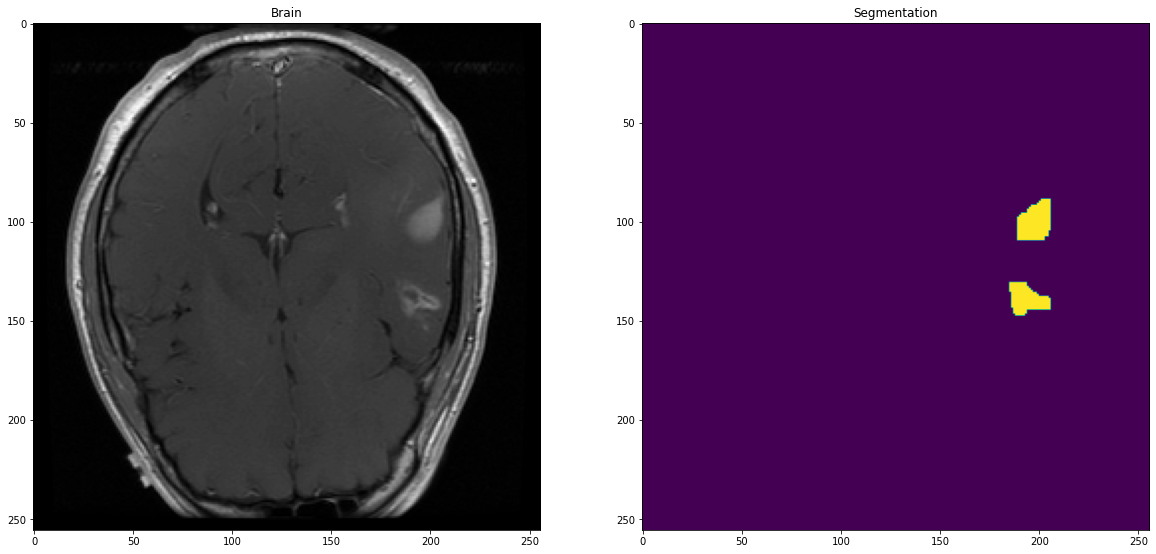

In [9]:
# Display the images to see how it looks like with the masked labels
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap="gray")
plt.title("Brain")
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(label)[12,:,:])        
plt.title("Segmentation")

plt.show()

## Extract the features

Using the `radiomics` package, first construct an `extractor` object using default settings.  We will then generate a baseline set of features.  Comparing the features after running `SimpleITK` filters will show which features are less sensitive.

In [12]:
import os

#### creating an extractor with default settings as we did in last notebook
extractor = featureextractor.RadiomicsFeatureExtractor()

## modifying some of the parameters
extractor.enableFeatureClassByName('shape', enabled=False)  # disable shape as it is independent of gray value
# Construct a set of SimpleITK filter objects to find features
filters = {
    "AdditiveGaussianNoise" : sitk.AdditiveGaussianNoiseImageFilter(),
    "Bilateral" : sitk.BilateralImageFilter(),
    "BinomialBlur" : sitk.BinomialBlurImageFilter(),
    "BoxMean" : sitk.BoxMeanImageFilter(),
    "BoxSigmaImageFilter" : sitk.BoxSigmaImageFilter(),
    "CurvatureFlow" : sitk.CurvatureFlowImageFilter(),
    "DiscreteGaussian" : sitk.DiscreteGaussianImageFilter(),
    "LaplacianSharpening" : sitk.LaplacianSharpeningImageFilter(),
    "Mean" : sitk.MeanImageFilter(),
    "Median" : sitk.MedianImageFilter(),
    "Normalize" : sitk.NormalizeImageFilter(),
    "RecursiveGaussian" : sitk.RecursiveGaussianImageFilter(),
    "ShotNoise" : sitk.ShotNoiseImageFilter(),
    "SmoothingRecursiveGaussian" : sitk.SmoothingRecursiveGaussianImageFilter(),
    "SpeckleNoise" : sitk.SpeckleNoiseImageFilter(),
}

In [13]:
# Filter - available or intitialized to apply
results = {}

results["baseline"] = extractor.execute(image, label)

for key, value in six.iteritems(filters):
    print ( "filtering with " + key )
    filtered_image = value.Execute(image)
    results[key] = extractor.execute(filtered_image, label)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with AdditiveGaussianNoise


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with Bilateral


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with BinomialBlur


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with BoxMean


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with BoxSigmaImageFilter


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with CurvatureFlow


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with DiscreteGaussian


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with LaplacianSharpening


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with Mean


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with Median


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with Normalize


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with RecursiveGaussian


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with ShotNoise


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with SmoothingRecursiveGaussian


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


filtering with SpeckleNoise


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


## Prepare for analysis

Determine which features had the highest variance.

In [14]:
# Keep an index of filters and features to find the important features using their varience values
filter_index = list(sorted(filters.keys()))
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results[filter_index[0]] )))

## Look at the features with highest and lowest coefficient of variation

The [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) gives a standardized measure of dispersion in a set of data.  Here we look at the effect of filtering on the different features.

**Spoiler alert** As might be expected, the grey level based features, e.g. `ClusterShade`, `LargeAreaEmphasis`, etc. are most affected by filtering, and shape metrics (based on label mask only) are the least affected.

In [15]:
# Pull in scipy to help find cv
import scipy.stats

features = {}
cv = {}

for key in feature_names:
    a = np.array([])
    for f in filter_index:
        a = np.append(a, results[f][key])
    features[key] = a
    cv[key] = scipy.stats.variation(a)
    
# a sorted view of cv
cv_sorted = sorted(cv, key=cv.get, reverse=True)

# Print the top 10
print ("\n")
print ("Top 10 features with largest coefficient of variation")
for i in range(0,10):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))
    
print ("\n")
print ("Bottom 10 features with _smallest_ coefficient of variation")
for i in range(-11,-1):
    print ("Feature: {:<50} CV: {}".format ( cv_sorted[i], cv[cv_sorted[i]]))



Top 10 features with largest coefficient of variation
Feature: original_ngtdm_Coarseness                          CV: 3.7416572627733893
Feature: original_glszm_LargeAreaLowGrayLevelEmphasis       CV: 3.7415428788948057
Feature: original_glszm_LargeAreaEmphasis                   CV: 3.738220411210843
Feature: original_glcm_ClusterShade                         CV: 3.736457237417057
Feature: original_glszm_ZoneVariance                        CV: 3.732272398289891
Feature: original_glrlm_LongRunLowGrayLevelEmphasis         CV: 3.7201705797490523
Feature: original_glcm_ClusterProminence                    CV: 3.7182116380099717
Feature: original_gldm_LargeDependenceLowGrayLevelEmphasis  CV: 3.6605897510491787
Feature: original_ngtdm_Complexity                          CV: 3.6473897824605244
Feature: original_glszm_LargeAreaHighGrayLevelEmphasis      CV: 3.5275833434349884


Bottom 10 features with _smallest_ coefficient of variation
Feature: original_glrlm_RunLengthNonUniformity         